# Phosphorus predictive model

This script performs a phosphorus budget on a lake using a two-box model. This phosphorus budget is applied on past data with known TP concentrations to determine the relative contribution of external and internal phosphorus loads. This approach can be applied on monomictic lakes with a summer stratified period and a winter mixed period.

**Author**: Tomy Doda, Surface Waters - Research and Management, Eawag\
**Last update**: 21.04.2024

#### Required packages:
- numpy
- matplotlib
- pandas
- cmocean
- scipy

In [1]:
# Import the packages
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'svg.fonttype':'none', 'font.sans-serif':'Arial','font.size': 12}) # "none": to export text as text
import pandas as pd
from datetime import datetime, timezone, UTC, timedelta
import math
import cmocean
from functions import *
%matplotlib widget 

#### Parameters

In [2]:
#lakename="LakeMurten"
lakename="LakeBaldegg"

In [3]:
method_Pin="curve" # Options: "obs" (compute Pin from observations of TPin), "curve" (compute Pin from created Q-TPin curve), "function" (compute Pin from provided function Q=f(TPin) in function file)
method_epi="varying" # Options: "constant" (constant thermocline depth set during stratified period in Lake_info.csv), "varying" (thermocline depth 
# measured or modeled at different time steps)
method_anox="stratif" # Options: "stratif" (anoxic period matches stratified period), "specified" (the start of the anoxic period is specified manually in lake_info.csv),
# "estimated" (anoxic period based on empirical equation from Müller et al., (2012)).
method_netsed="Vollenweider" # Options: "Vollenweider", "Hanson" (only used in predictive model to compute the net sedimentation rate)

Time for which the phosphorus budget must be computed (if empty, use the time from the inflow data or the TP data depending which one has the lowest frequency):

In [4]:
# tdate_budget=np.array([]) # Example: tdate_budget=np.array([datetime(2024,1,1),datetime(2024,1,2),datetime(2024,1,3)]) 
#tdate_min_max=np.array([datetime(2008,1,1),datetime(2015,12,31)]) # If empty, time is the inflow data time
#tdate_min_max=np.array([datetime(2002,1,1),datetime(2015,12,31)]) # If empty, time is the inflow data time
tdate_min_max=np.array([datetime(1985,4,1),datetime(1999,12,31)]) # If empty, time is the inflow data time
#tdate_min_max=np.array([])

if tdate_min_max.size>0:
    tdate_list=[tdate_min_max[0]]

    while tdate_list[-1]<datetime(tdate_min_max[1].year,tdate_min_max[1].month,1):                                                  
        month_nb=tdate_list[-1].month
        year_nb=tdate_list[-1].year
        if month_nb==12:
            month_nb=1
            year_nb+=1
        else:
            month_nb+=1
        tdate_list.append(datetime(year_nb,month_nb,1))
    tdate_budget=np.array(tdate_list) # Monthly interval
else:
    tdate_list=[]

In [5]:
savefig_bool=False

## 1. Load the data

In [6]:
#date_format = lambda x: pd.to_datetime(x, format="%d.%m")
df_lake=pd.read_csv("../Data/"+lakename+"/Lake_info.csv", sep=",",header=None,skiprows=1,usecols=[1],dtype=str) # Lake information
df_lake=df_lake.T # Transpose
df_lake.columns=["z_epi","t_stratif_start","t_stratif_end","t_anoxic_start","T_epi","T_hypo","TPsed","Kz","sigma_max","NS_max"]
df_lake.to_csv('lake_parameters.csv', sep=",",index=False,header=True) # Save the transposed dataframe
df_lake=pd.read_csv("lake_parameters.csv", sep=",",header=0,parse_dates=["t_stratif_start","t_stratif_end","t_anoxic_start"],date_format="%d.%m") # Load it again to have the correct date format 
Kz=df_lake["Kz"][0]
TPsed=df_lake["TPsed"][0]

In [7]:
df_hypso=pd.read_csv("../Data/"+lakename+"/Hypsometry.csv", sep=",",header=0,names=["z_hypso","A_hypso"]) # Hypsometry
z_hypso=df_hypso["z_hypso"].to_numpy()
df_lake["z_max"]=np.max(z_hypso)
A_hypso=df_hypso["A_hypso"].to_numpy()
A0=A_hypso[z_hypso==0]
V_hypso=np.concatenate((np.mean([A_hypso[1:],A_hypso[:-1]],axis=0)*(z_hypso[1:]-z_hypso[:-1]),np.array([0]))) # Volume of each layer [m3]
V_lake=np.nansum(V_hypso) # [m3]
z_mean=V_lake/A0 # [m]

In [8]:
#date_format = lambda x: pd.to_datetime(x, format='%d.%m.%Y')
simstrat_file="../Data/"+lakename+"/"+lakename+"_T_SIMSTRAT.dat"
df_inflows=pd.read_csv("../Data/"+lakename+"/Inflows.csv", sep=",",parse_dates=["Date"],date_format='%d.%m.%Y') # Inflows
#df_outflows=pd.read_csv("..\Data\\"+lakename+"\Outflows.csv", sep=",",parse_dates=["Date"],date_parser=date_format) # Outflows
df_TP=pd.read_csv("../Data/"+lakename+"/TP.csv", sep=",") # TP concentrations (to compare with model)
tdate_TP=np.array([datetime.strptime(datestr,"%d/%m/%Y") for datestr in df_TP.columns[1:]]) # Dates with measured TP
tnum_TP=np.array([d.replace(tzinfo=timezone.utc).timestamp() for d in tdate_TP])

In [9]:
if method_Pin=="curve" or method_Pin=="function":
    df_Q=pd.read_csv("../Data/"+lakename+"/Discharges.csv", sep=",",parse_dates=["Date"],date_format='%d.%m.%Y') 
    tnum_Q=df_Q["Date"].to_numpy().astype('datetime64[s]').astype(np.int64)
    tdate_Q=df_Q["Date"].to_numpy().astype('datetime64[s]').astype(datetime)
    Qval=df_Q.values[:,np.arange(1,len(df_Q.columns),1)].astype(float)

Set the time for the budget:

In [10]:
if not list(tdate_budget): # Empty: take the time from the lowest frequency between inflow data and TP data
    if method_Pin!="obs":
        print("The model can only be run during the inflow measurement period because the simulation period has not been defined.")
    dt_inflows=np.nanmean(np.diff(df_inflows["Date"].to_numpy().astype('datetime64[s]').astype(np.int64)))
    dt_TP=np.nanmean(np.diff(tnum_TP))
    ind_low_freq=np.argmax(np.array([dt_inflows,dt_TP])) # Lowest frequency
    if ind_low_freq==0: # Take inflows time
        tdate_budget=df_inflows["Date"].to_numpy().astype('datetime64[s]').astype(datetime)
    else: # Take TP time
        tdate_budget=tdate_TP
    
    if list(tdate_min_max): # Not empty
        tdate_budget=tdate_budget[np.logical_and(tdate_budget>tdate_min_max[0],tdate_budget<tdate_min_max[1])]


In [11]:
tnum_budget=np.array([dateval.replace(tzinfo=timezone.utc).timestamp() for dateval in tdate_budget])

Compute the thermocline depth at each TP measurement timestep (from constant thermocline or from measured/modelled temperature):

In [12]:
if method_epi=="constant":
    tdate_start=df_lake["t_stratif_start"].to_numpy().astype('datetime64[s]').astype(datetime)[0]
    tdate_end=df_lake["t_stratif_end"].to_numpy().astype('datetime64[s]').astype(datetime)[0]
    hepi_TP=compute_hepi_constant(tdate_TP,tdate_start,tdate_end,hepi=df_lake["z_epi"][0],zmax=df_lake["z_max"][0]) # At time steps of TP measurements
    hepi_budget=compute_hepi_constant(tdate_budget,tdate_start,tdate_end,hepi=df_lake["z_epi"][0],zmax=df_lake["z_max"][0]) # At time steps of P budget
else:
    tnum_T, depth_T, tempval=extract_simstrat_T(simstrat_file) # Extract Simstrat temperature data
    bool_period=np.logical_and(tnum_T>=tnum_budget[0],tnum_T<=tnum_budget[-1]) # Select period of interest
    #hepi_TP,hepi_T=compute_hepi_varying(tnum_TP,tnum_T[bool_period],depth_T,tempval[:,bool_period],zmax=df_lake["z_max"][0]) # At time steps of TP measurements
    hepi_TP,hepi_T=compute_hepi_varying(tnum_TP,tnum_T,depth_T,tempval,zmax=df_lake["z_max"][0]) # At time steps of TP measurements
    hepi_budget,_=compute_hepi_varying(tnum_budget,tnum_T[bool_period],depth_T,tempval[:,bool_period],zmax=df_lake["z_max"][0]) # At time steps of P budget
    
Vepi=np.full(len(hepi_budget),np.nan)
Atherm=np.full(len(hepi_budget),np.nan)
for kt in range(len(hepi_budget)):
    Vepi[kt]=np.nansum(V_hypso[z_hypso<=hepi_budget[kt]])
    Atherm[kt]=A_hypso[np.where(z_hypso>=hepi_budget[kt])[0][0]]
hepi_model=Vepi/A0 # Thermocline depth for a box of the same volume as the epilimnion

Tepi, Thypo

In [13]:
depthval=df_TP["Depth [m]"].values
TPepi,TPhypo=compute_TP_2boxes(depthval,df_TP.values[:,1:],hepi_TP)
# Temperature in epilimnion and hypolimnion:
if method_epi=="varying":
    #T_epi,T_hypo=compute_TP_2boxes(depth_T,tempval[:,bool_period],hepi_T)
    #T_epi=np.interp(tnum_TP,tnum_T[bool_period],T_epi)
    #T_hypo=np.interp(tnum_TP,tnum_T[bool_period],T_hypo)
    T_epi,T_hypo=compute_TP_2boxes(depth_T,tempval,hepi_T)
    T_epi=np.interp(tnum_TP,tnum_T,T_epi)
    T_hypo=np.interp(tnum_TP,tnum_T,T_hypo)
else:
    T_epi=np.full(len(tnum_TP),df_lake["T_epi"][0]) # Annual average
    T_hypo=np.full(len(tnum_TP),df_lake["T_hypo"][0])
T_epi_budget=np.interp(tnum_budget,tnum_TP,T_epi)
T_hypo_budget=np.interp(tnum_budget,tnum_TP,T_hypo)

Initial conditions

In [14]:
TPepi_0=TPepi[np.argmin(np.abs(tnum_TP-tnum_budget[0]))]
TPhypo_0=TPhypo[np.argmin(np.abs(tnum_TP-tnum_budget[0]))]

In [15]:
TPepi_compare=TPepi[np.logical_and(tnum_TP>=tnum_budget[0],tnum_TP<=tnum_budget[-1])]
TPhypo_compare=TPhypo[np.logical_and(tnum_TP>=tnum_budget[0],tnum_TP<=tnum_budget[-1])]
tdate_compare=tdate_TP[np.logical_and(tnum_TP>=tnum_budget[0],tnum_TP<=tnum_budget[-1])]

Text(0, 0.5, 'TP [mg m$^{-3}$]')

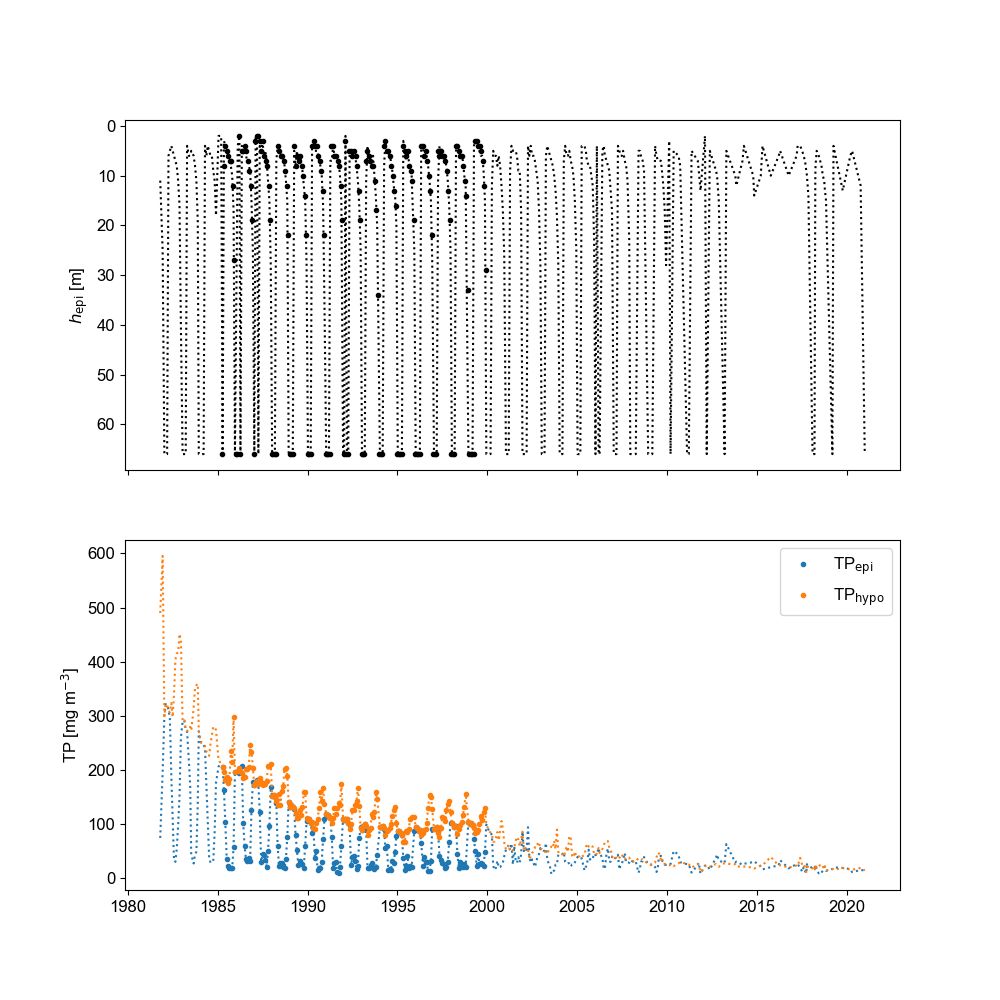

In [16]:
fig,ax=plt.subplots(2,1,figsize=(10,10),sharex=True)
#ax[0].plot([datetime.fromtimestamp(tnum,UTC) for tnum in tnum_T],hepi_T,'-k')
ax[0].plot(tdate_TP,hepi_TP,':k')
ax[0].plot(tdate_budget,hepi_budget,'.k')
ax[0].set_ylabel('$h_{\\rm epi}$ [m]')
ax[0].invert_yaxis()

ax[1].plot(tdate_TP,TPepi,':',color="C0")
p1,=ax[1].plot(tdate_compare,TPepi_compare,'.',color="C0")
ax[1].plot(tdate_TP,TPhypo,':',color="C1")
p2,=ax[1].plot(tdate_compare,TPhypo_compare,'.',color="C1")
plt.legend([p1,p2],['TP$_{\\rm epi}$','TP$_{\\rm hypo}$'])
ax[1].set_ylabel('TP [mg m$^{-3}$]')

## 2. Compute the terms of the mass balance

#### Phosphorus load from inflows ($P_{\rm in}$)

In [17]:
tnum_inflows=df_inflows["Date"].to_numpy().astype('datetime64[s]').astype(np.int64)
tdate_inflows=df_inflows["Date"].to_numpy().astype('datetime64[s]').astype(datetime)
Q_inflows=df_inflows.values[:,np.arange(1,len(df_inflows.columns),2)].astype(float)
TP_inflows=df_inflows.values[:,np.arange(2,len(df_inflows.columns),2)].astype(float)

In [18]:
if method_Pin=="obs":
    Pin,Qin_budget,tnum_budget2=compute_river_load_from_obs(tnum_inflows,Q_inflows,TP_inflows,tnum_budget,calculation="average") # [tons-P yr-1]
    valkeep=~np.isnan(Pin)
    Pin=Pin[valkeep]
    tnum_budget=tnum_budget[valkeep]
    tdate_budget=tdate_budget[valkeep]
elif method_Pin=="curve": # From Q-TP curve
    # 1- Inflow-specific curve
    Pin,Qin_curve,tnum_budget2,param_curve,R2=compute_river_load_from_curve(Q_inflows,TP_inflows,tnum_Q,Qval,tnum_budget,method="power",calculation="average") # [tons-P yr-1]

    # 2- Global curve:
    Qin_tot=np.sum(Q_inflows,axis=1)
    TPin_tot=np.sum(Q_inflows*TP_inflows,axis=1)/Qin_tot
    Qval_tot=np.sum(Qval,axis=1)
    Pin_global,Qin_curve_global,tnum_budget_global,param_curve_global,R2_global=compute_river_load_from_curve(np.array([Qin_tot,]).transpose(),np.array([TPin_tot,]).transpose(),tnum_Q,np.array([Qval_tot,]).transpose(),tnum_budget,method="power",calculation="average") # [tons-P yr-1]

    # Print parameters of relationship of Müller et al. (2012) with Q [1e6 m3/yr] and TP [ug/L]
    a_param=param_curve[0,:]*(1e6/(365*24*3600))**param_curve[1,:]
    print("Parameters (inflow-specific): a={},b={}".format(a_param,param_curve[1,:])) 
    a_param_global=param_curve_global[0,0]*(1e6/(365*24*3600))**param_curve_global[1,0]
    print("Parameters (global): a={:.2f},b={:.2f}".format(a_param_global,param_curve_global[1,0]))
elif method_Pin=="function":
    Qin_tot=np.sum(Qval,axis=1)
    TPin_curve=discharge_TP(tnum_Q,Qin_tot)
    #Pin_budget=np.interp(tnum_budget,tnum_Q,TPin_curve*Qin_tot*86400*365*1e-9)
    #Qin_budget=np.interp(tnum_budget,tnum_Q,Qin_tot)
    #tnum_budget2=tnum_budget.copy()
    tnum_budget2,Pin_budget,_=average_between(tnum_budget,tnum_Q,TPin_curve*Qin_tot*86400*365*1e-9) # Average between dates
    _,Qin_budget,_=average_between(tnum_budget,tnum_Q,Qin_tot)
    Pin=np.concatenate((Pin_budget,np.array([np.nan])),axis=0) # Add a nan value at the end
    tnum_budget2=np.concatenate((tnum_budget,np.array([np.nan])),axis=0) # Add a nan value at the end      
    Qin_budget=np.concatenate((Qin_budget,np.array([np.nan])),axis=0) # Add a nan value at the end
else:
    raise Exception("Wrong Pin method specified")

Parameters (inflow-specific): a=[ 31.83799893  50.26788033  61.89864398 110.76039159  57.55155986],b=[0.58388941 0.66619399 0.44864613 0.47260417 0.57081302]
Parameters (global): a=21.88,b=0.60


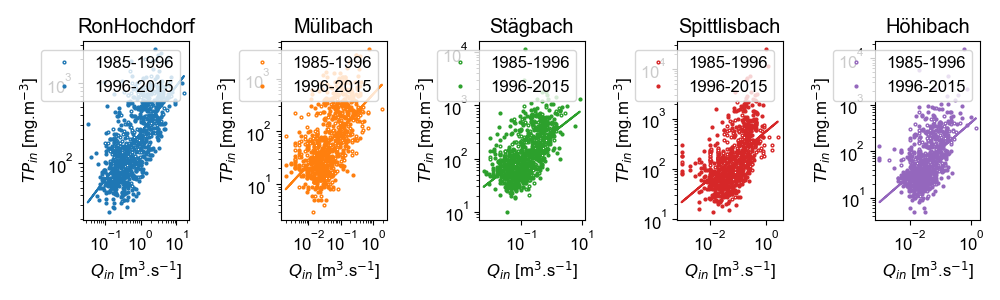

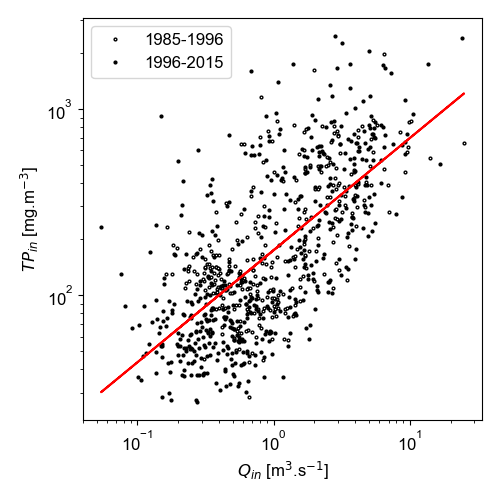

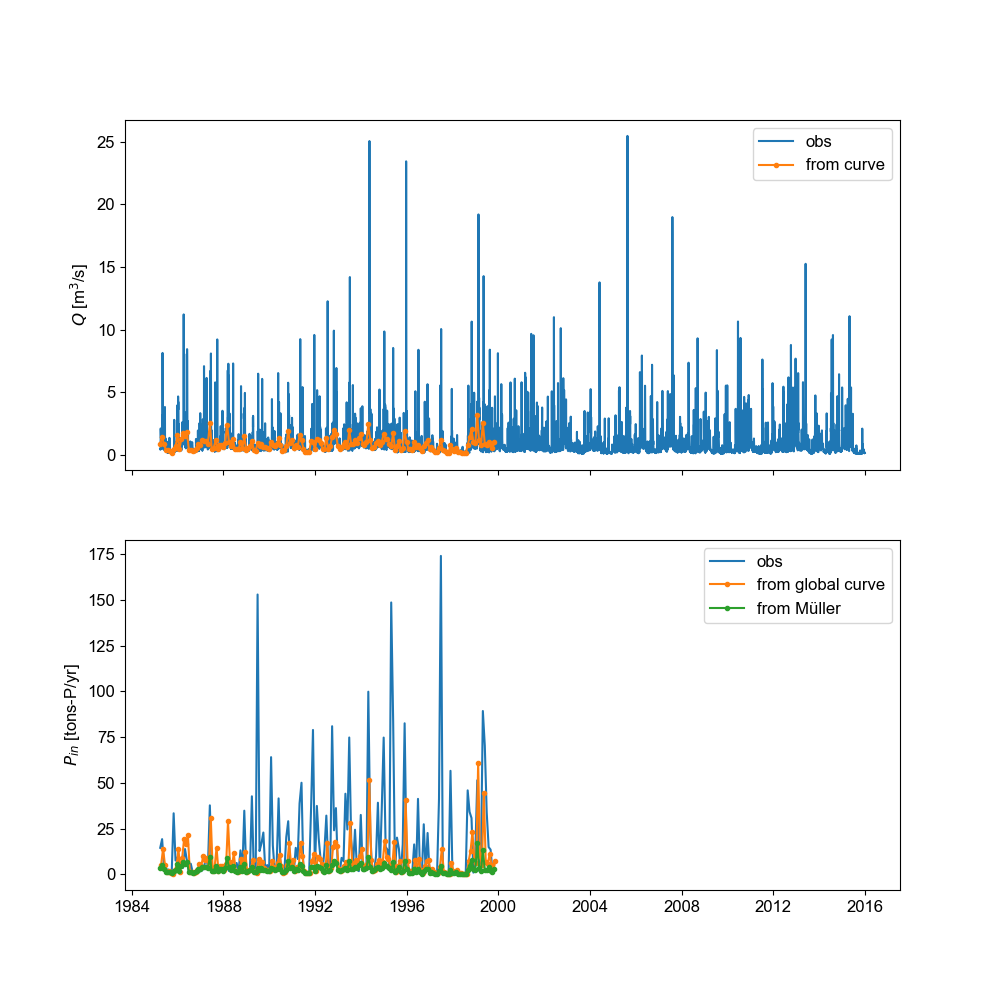

In [19]:
if method_Pin=="curve": 
    Pin_obs,_,_=compute_river_load_from_obs(tnum_inflows,Q_inflows,TP_inflows,tnum_budget,calculation="average") # [tons-P yr-1]
    
    # Q-TP curves for each inflow
    fig,ax=plt.subplots(1,Q_inflows.shape[1],figsize=(10,3))
    col_inflows=plt.get_cmap("tab10")
    hp_all=[]
    legname=[]
    period1_logical=tnum_inflows<datetime(1996,1,1).replace(tzinfo=timezone.utc).timestamp()
    for kin in range(Q_inflows.shape[1]):
        
        hp1,=ax[kin].plot(Q_inflows[np.logical_and(period1_logical,Q_inflows[:,kin]>0),kin],TP_inflows[np.logical_and(period1_logical,Q_inflows[:,kin]>0),kin],
                'o',markersize=2,color=col_inflows(kin),markerfacecolor='w')
        hp2,=ax[kin].plot(Q_inflows[np.logical_and(~period1_logical,Q_inflows[:,kin]>0),kin],TP_inflows[np.logical_and(~period1_logical,Q_inflows[:,kin]>0),kin],
                    'o',markersize=2,color=col_inflows(kin))
        ax[kin].plot(Q_inflows[Q_inflows[:,kin]>0,kin],param_curve[0,kin]*Q_inflows[Q_inflows[:,kin]>0,kin]**param_curve[1,kin],'-',color=col_inflows(kin))
        ax[kin].set_xscale("log")
        ax[kin].set_yscale("log")
        ax[kin].legend([hp1,hp2],["1985-1996","1996-2015"])
        column_name=df_inflows.columns[2*kin+1]
        ax[kin].set_title(column_name[2:column_name.find(" [m3")])
        ax[kin].set_xlabel("$Q_{in}$ [m$^{3}$.s$^{-1}$]")
        ax[kin].set_ylabel("$TP_{in}$ [mg.m$^{-3}$]")
    fig.set_tight_layout(True)

    # Global Q-TP curve
    fig,ax=plt.subplots(1,1,figsize=(5,5))
    hp1,=ax.plot(Qin_tot[np.logical_and(period1_logical,Qin_tot>0)],TPin_tot[np.logical_and(period1_logical,Qin_tot>0)],
            'ko',markersize=2,markerfacecolor='w')
    hp2,=ax.plot(Qin_tot[np.logical_and(~period1_logical,Qin_tot>0)],TPin_tot[np.logical_and(~period1_logical,Qin_tot>0)],
            'ko',markersize=2)
    ax.plot(Qin_tot[Qin_tot>0],param_curve_global[0,0]*Qin_tot[Qin_tot>0]**param_curve_global[1,0],'r-')
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend([hp1,hp2],["1985-1996","1996-2015"])
    ax.set_xlabel("$Q_{in}$ [m$^{3}$.s$^{-1}$]")
    ax.set_ylabel("$TP_{in}$ [mg.m$^{-3}$]")
    fig.set_tight_layout(True)

    # Time series
    fig,ax=plt.subplots(2,1,figsize=(10,10),sharex=True)
    ax[0].plot(tdate_Q,np.nansum(Qval,axis=1))
    ax[0].plot(tdate_budget,Qin_curve,'.-')
    ax[0].set_ylabel("$Q$ [m$^3$/s]")
    ax[0].legend(["obs","from curve"])

    #Pin based on the Q-TP relationship from Müller et al. (2012)
    Qin_tot_M=np.sum(Qval,axis=1)
    TPin_curve_M=discharge_TP(tnum_Q,Qin_tot_M)
    #Pin_M1=np.interp(tnum_budget,tnum_Q,TPin_curve_M*Qin_tot_M,left=np.nan,right=np.nan)*86400*365*1e-9 # [tons-P yr-1]
    tnum_budget2,Pin_M2,_=average_between(tnum_budget,tnum_Q,TPin_curve_M*Qin_tot_M*86400*365*1e-9) # Average between dates
    Pin_M2=np.concatenate((Pin_M2,np.array([np.nan])))
    
    ax[1].plot(tdate_budget,Pin_obs)
    #ax[1].plot(tdate_budget,Pin)
    tdate_budget_global=np.full(tnum_budget_global.shape,None)
    tdate_budget_global[~np.isnan(tnum_budget_global)]=np.array([datetime.fromtimestamp(tnum,UTC) for tnum in tnum_budget_global[~np.isnan(tnum_budget_global)]])
    ax[1].plot(tdate_budget_global[tdate_budget_global!=None],Pin_global[tdate_budget_global!=None],'.-')
    ax[1].plot(tdate_budget,Pin_M2,'.-')
    ax[1].legend(["obs","from global curve","from Müller"])
    ax[1].set_ylabel("$P_{in}$ [tons-P/yr]")
elif method_Pin=="obs":
    # Time series
    fig,ax=plt.subplots(2,1,figsize=(10,10),sharex=True)
    p1,=ax[0].plot(tdate_inflows,np.sum(Q_inflows,axis=1),'.-',color="C0")
    ax[0].set_ylabel("$Q$ [m$^3$/s]")
    ax_right = ax[0].twinx()
    p2,=ax_right.plot(tdate_inflows,np.sum(Q_inflows*TP_inflows,axis=1)/np.sum(Q_inflows,axis=1),'.-',color="C1")
    ax_right.set_ylabel("$TP_{\\rm in}$ [mg.m$^{-3}$]")
    ax[0].legend([p1,p2],["$Q$","$TP_{\\rm in}$"])

    ax[1].plot(tdate_inflows,np.sum(Q_inflows*TP_inflows*86400*365*1e-9,axis=1),'k.-')
    ax[1].plot(tdate_budget,Pin,'r.-')
    ax[1].set_ylabel("$P_{\\rm in}$ [tons.yr$^{-1}$]")
    ax[1].legend(["obs","averaged"])


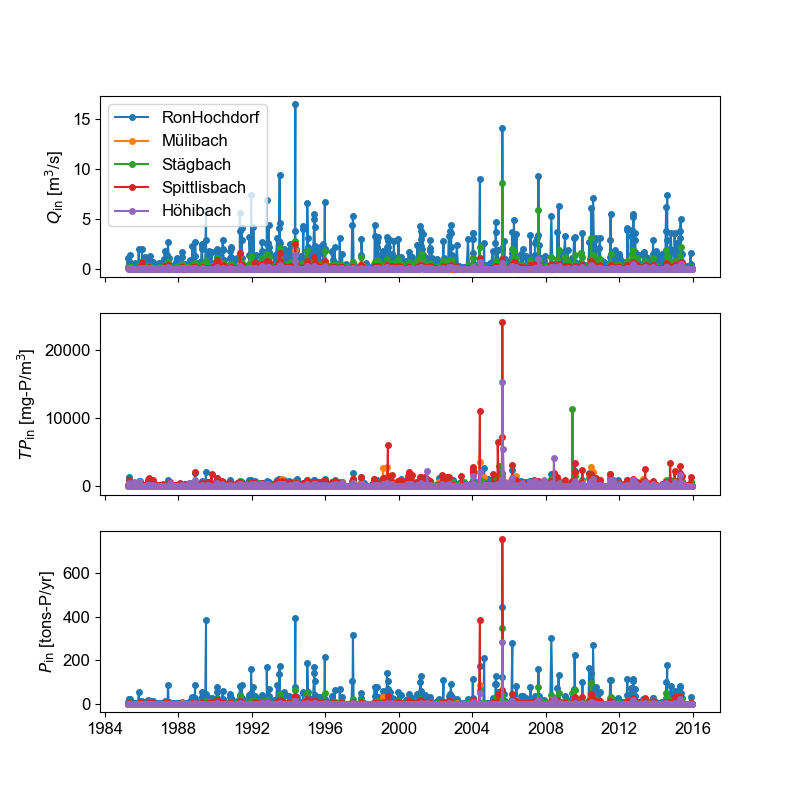

In [20]:
fig,ax=plt.subplots(3,1,figsize=(8,8),sharex=True)
legname=[]
for kriver in range(Q_inflows.shape[1]):
    column_name=df_inflows.columns[2*kriver+1]
    legname.append(column_name[2:column_name.find(" [m3")])
    ax[0].plot(df_inflows["Date"],Q_inflows[:,kriver],'.-',markersize=8)
    ax[1].plot(df_inflows["Date"],TP_inflows[:,kriver],'.-',markersize=8)
    ax[2].plot(df_inflows["Date"],Q_inflows[:,kriver]*TP_inflows[:,kriver]*86400*365*1e-9,'.-',markersize=8)
ax[0].set_ylabel('$Q_{\\rm in}$ [m$^3$/s]')
ax[1].set_ylabel('$TP_{\\rm in}$ [mg-P/m$^3$]')
ax[2].set_ylabel('$P_{\\rm in}$ [tons-P/yr]')
ax[0].legend(legname)

# Save figure
if savefig_bool:
    fig.savefig("../Figures/Pin.png",dpi=400)
    fig.savefig("../Figures/Pin.svg")
    print('Figure saved!')

## 3. Predictive mass balance model

In [21]:
if method_Pin=="curve":
    Qout_budget=Qin_curve # Assumption: Qout=Qin
else: 
    Qout_budget=Qin_budget # Assumption: Qout=Qin

In [22]:
if method_anox=="stratif":
    bool_anox=hepi_budget<df_lake["z_max"][0]
elif method_anox=="specified":
    bool_anox=compute_anoxia_dates(tdate_budget,df_lake["t_anoxic_start"].to_numpy().astype('datetime64[s]').astype(datetime)[0],hepi_budget,df_lake["z_max"][0]) 
else:
    if method_epi=="varying":
        # Determine stratified periods accurately
        tnum_stratif=compute_stratified_periods(tnum_T[bool_period],hepi_T,df_lake["z_max"][0])
    else:
        all_years=np.array([tdate.year for tdate in tdate_budget])
        unique_years=np.unique(all_years)
        tnum_stratif=np.full((2,len(unique_years)),np.nan)
        for ky in range(len(unique_years)):
            tnum_stratif[:,ky]=np.array([datetime(unique_years[ky],tdate_start.month,tdate_start.day).replace(tzinfo=timezone.utc).timestamp(),\
                               datetime(unique_years[ky],tdate_end.month,tdate_end.day).replace(tzinfo=timezone.utc).timestamp()])
    bool_anox,ndays_to_anox,tstart_anox=compute_anoxia_red(tnum_budget,hepi_model,z_mean,tnum_stratif=tnum_stratif)

In [23]:
if type(df_lake["sigma_max"][0])==np.float64:
    sigma_max=df_lake["sigma_max"][0]
else:
    sigma_max=np.nan
    
if type(df_lake["NS_max"][0])==np.float64:
    P_NS_max=df_lake["NS_max"][0] 
else:
    P_NS_max=np.nan

#MODIFY parameters
#P_NS_max=4.2
#TPcritval=30
#P_NS_max=np.nan
TPcrit=np.nan
Pin2=Pin
TPsed2=TPsed


tnum_predict,TPepi_predict,TPepi_range,TPhypo_predict,TPhypo_range,P_fluxes,param=predict_TP_model(tnum_budget,bool_anox,Pin2,Qout_budget,hepi_budget,TPepi_0,TPhypo_0,TPsed2,\
                                                                                   z_hypso,A_hypso,T_hypo_budget,T_epi_budget,sigma_max=sigma_max,P_NS_max=P_NS_max,TPcrit=TPcrit,\
                                                                                             method_sed=method_netsed,method_remob="average",show_output=True)

1985-04-01 00:00:00+00:00: TP_lake=206.29 mg/m3, P_NS=4.80 tons/yr, sigma_max=0.50 yr-1, TPcrit=55.07 mg/m3
1985-05-01 00:00:00+00:00: TP_lake=203.74 mg/m3, P_NS=4.80 tons/yr, sigma_max=0.50 yr-1, TPcrit=55.07 mg/m3
1985-06-01 00:00:00+00:00: TP_lake=203.52 mg/m3, P_NS=4.80 tons/yr, sigma_max=0.50 yr-1, TPcrit=55.07 mg/m3
1985-07-01 00:00:00+00:00: TP_lake=203.01 mg/m3, P_NS=4.80 tons/yr, sigma_max=0.50 yr-1, TPcrit=55.07 mg/m3
1985-08-01 00:00:00+00:00: TP_lake=201.13 mg/m3, P_NS=4.80 tons/yr, sigma_max=0.50 yr-1, TPcrit=55.07 mg/m3
1985-09-01 00:00:00+00:00: TP_lake=199.49 mg/m3, P_NS=4.80 tons/yr, sigma_max=0.50 yr-1, TPcrit=55.07 mg/m3
1985-10-01 00:00:00+00:00: TP_lake=200.60 mg/m3, P_NS=4.80 tons/yr, sigma_max=0.50 yr-1, TPcrit=55.07 mg/m3
1985-11-01 00:00:00+00:00: TP_lake=198.43 mg/m3, P_NS=4.80 tons/yr, sigma_max=0.50 yr-1, TPcrit=55.07 mg/m3
1985-12-01 00:00:00+00:00: TP_lake=196.68 mg/m3, P_NS=4.80 tons/yr, sigma_max=0.50 yr-1, TPcrit=55.07 mg/m3
1986-01-01 00:00:00+00:00: T

In [24]:
# Load data from Müller et al. (2012)
#df_Muller_obs=pd.read_excel(r"C:\Users\tdoda\OneDrive - Université de Lausanne\External drive\Data\Phosphorus\Baldeggersee_Muller\table2_paper_2012.xlsx",sheet_name="Obs",skiprows=[1,2],
#                       parse_dates=["Jahr"])
df_Muller_model=pd.read_excel(r"C:\Users\tdoda\OneDrive - Université de Lausanne\External drive\Data\Phosphorus\Baldeggersee_Muller\table2_paper_2012.xlsx",sheet_name="Model",skiprows=np.concatenate((np.arange(0,4),np.array([5,6]))),
                       parse_dates=["Jahr"])

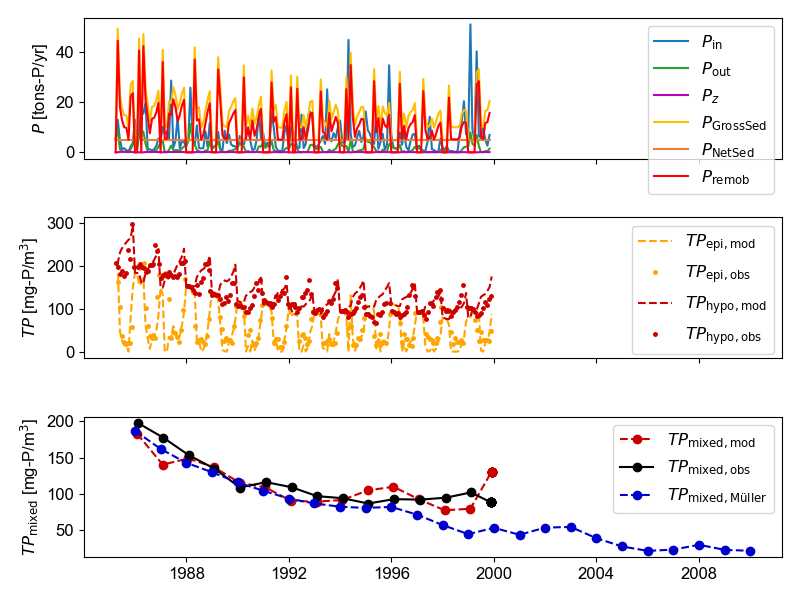

In [25]:
fig,ax=plt.subplots(3,1,figsize=(8,6),sharex=True)
colplots=plt.get_cmap('tab10')
col_yellow=(1,190/255,0)
col_orange=(240/255,125/255,50/255)
tdate_predict=np.array([datetime.fromtimestamp(tnum,UTC) for tnum in tnum_predict])

ax[0].plot(tdate_budget,P_fluxes["Pin"],'-',color=colplots(0))
ax[0].plot(tdate_budget,P_fluxes["Pout_epi"],'-',color=colplots(2))
ax[0].plot(tdate_budget,P_fluxes["Pz"],'-',color='m')
ax[0].plot(tdate_budget,P_fluxes["Premob"]+P_fluxes["Pnet_sed"],'-',color=col_yellow)
ax[0].plot(tdate_budget,P_fluxes["Pnet_sed"],'-',color=col_orange)
ax[0].plot(tdate_budget,P_fluxes["Premob"],'-',color='r')
ax[0].set_ylabel('$P$ [tons-P/yr]')
ax[0].legend(["$P_{\\rm in}$","$P_{\\rm out}$","$P_{z}$","$P_{\\rm GrossSed}$","$P_{\\rm NetSed}$","$P_{\\rm remob}$"])

p1,=ax[1].plot(tdate_predict,TPepi_predict,'--',color='orange')
# ax[1].fill_between(np.concatenate((tdate_predict,np.flip(tdate_predict))),np.concatenate((TPepi_range[0,:],np.flip(TPepi_range[1,:]))),\
#                    facecolor='orange',edgecolor=None,alpha=0.2)
p2,=ax[1].plot(tdate_compare,TPepi_compare,'.',color='orange',markersize=5)
p3,=ax[1].plot(tdate_predict,TPhypo_predict,'--',color=(0.8,0,0))
# ax[1].fill_between(np.concatenate((tdate_predict,np.flip(tdate_predict))),np.concatenate((TPhypo_range[0,:],np.flip(TPhypo_range[1,:]))),\
#                    facecolor=(0.8,0,0),edgecolor=None,alpha=0.2)
p4,=ax[1].plot(tdate_compare,TPhypo_compare,'.',color=(0.8,0,0),markersize=5)
ax[1].set_ylabel('$TP$ [mg-P/m$^3$]')
ax[1].legend([p1,p2,p3,p4],["$TP_{\\rm epi,mod}$","$TP_{\\rm epi,obs}$","$TP_{\\rm hypo,mod}$","$TP_{\\rm hypo,obs}$"])

TPlake_obs=np.nanmean(np.array([TPepi_compare,TPhypo_compare]),axis=0)
TPlake_mod=np.nanmean(np.array([TPepi_predict,TPhypo_predict]),axis=0)
# Define the mixing period from 1st Feb
ind_mod=[np.argmin(np.abs(tdate_predict-dt.replace(tzinfo=timezone.utc))) for dt in df_Muller_model["Jahr"].values.astype("datetime64[s]").astype(datetime)+timedelta(days=31)]
ind_obs=[np.argmin(np.abs(tdate_compare-dt)) for dt in df_Muller_model["Jahr"].values.astype("datetime64[s]").astype(datetime)+timedelta(days=31)]
p1,=ax[2].plot(tdate_predict[ind_mod],TPlake_mod[ind_mod],'o--',color=(0.8,0,0))
p2,=ax[2].plot(tdate_compare[ind_obs],TPlake_obs[ind_obs],'ko-')
p3,=ax[2].plot(df_Muller_model["Jahr"].values,df_Muller_model["TPmod"].values,'o--',color=(0,0,0.8))
ax[2].set_ylabel('$TP_{\\rm mixed}$ [mg-P/m$^3$]')
ax[2].legend([p1,p2,p3],["$TP_{\\rm mixed,mod}$","$TP_{\\rm mixed,obs}$","$TP_{\\rm mixed,Müller}$"])

fig.set_tight_layout(True)

In [26]:
# Save figure
if savefig_bool:
    fig.savefig("../Figures/TP_predict_long_"+method_Pin+".png",dpi=400)
    fig.savefig("../Figures/TP_predict__long"+method_Pin+".svg")
    print('Figure saved!')

C:\Users\tdoda\AppData\Local\Temp\ipykernel_21916\4082058267.py:40: RuntimeWarning: All-NaN slice encountered
  ratio_max=np.nanmax(ratio_val,axis=0)
C:\Users\tdoda\AppData\Local\Temp\ipykernel_21916\4082058267.py:41: RuntimeWarning: All-NaN slice encountered
  ratio_min=np.nanmin(ratio_val,axis=0)


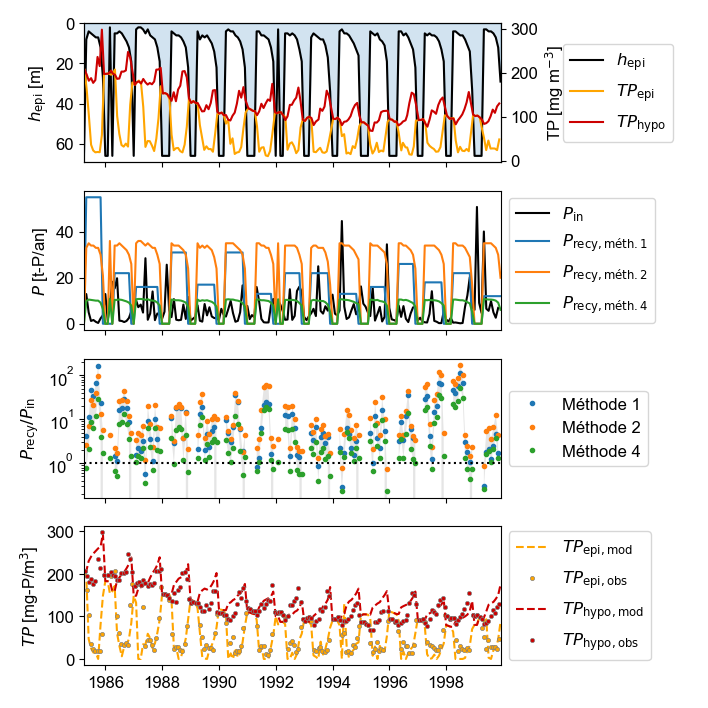

In [37]:
# Figure summary
figsize_cm=[18,18]
fig,ax=plt.subplots(4,1,figsize=(figsize_cm[0]/2.54,figsize_cm[1]/2.54),sharex=True)
colplots=plt.get_cmap('tab10')
tdate_predict=np.array([datetime.fromtimestamp(tnum,UTC) for tnum in tnum_predict])

# 1. Epilimnion + obs TPepi/hypo
ind_TP=np.logical_and(tnum_TP>tnum_budget[0],tnum_TP<tnum_budget[-1])
p1,=ax[0].plot(tdate_budget,hepi_budget,'k-')
p1b=ax[0].fill_between(tdate_budget,hepi_budget,color='C0',alpha=0.2)
axlim=ax[0].get_ylim()
ax[0].set_ylim(0,axlim[1])
ax_right=ax[0].twinx()
p2,=ax_right.plot(tdate_TP[ind_TP],TPepi[ind_TP],'-',color='orange')
p3,=ax_right.plot(tdate_TP[ind_TP],TPhypo[ind_TP],'-',color=(0.8,0,0))
ax[0].legend([p1,p2,p3],["$h_{\\rm epi}$","$TP_{\\rm epi}$","$TP_{\\rm hypo}$"],bbox_to_anchor=(1.13,0.5),loc="center left")
ax[0].set_ylabel('$h_{\\rm epi}$ [m]')
#ax[0].set_ylim(0,z_mean)
ax[0].invert_yaxis()
ax[0].set_xlim(tdate_budget[0],tdate_budget[-1])
ax_right.set_ylabel('TP [mg m$^{-3}$]')


# 2. Pin, Premob *3 methods
Atherm=np.array([A_hypso[np.where(z_hypso>=hepi)[0][0]] for hepi in hepi_budget])
#Premob_Carter=P_fluxes["Premob"]
Premob_Carter=compute_remobilization_Carter(np.interp(tnum_budget,tnum_TP,TPepi),Atherm,avg=True)
Premob_Nurnberg=compute_remobilization_Nurnberg(TPsed,Atherm)
Vhypo=np.array([np.trapz(A_hypso[z_hypso>=hepi],z_hypso[z_hypso>=hepi]) for hepi in hepi_TP])
Premob_balance=compute_remobilization_hypo(tnum_budget,tnum_TP,TPhypo,Vhypo,hepi_budget,df_lake["z_max"].values)
ax[1].plot(tdate_budget,Pin,'k-')
ax[1].plot(tdate_budget,Premob_balance,'-')
ax[1].plot(tdate_budget,Premob_Carter,'-')
ax[1].plot(tdate_budget,Premob_Nurnberg,'-')
ax[1].legend(["$P_{\\rm in}$","$P_{\\rm recy,méth.1}$","$P_{\\rm recy,méth.2}$","$P_{\\rm recy,méth.4}$"],bbox_to_anchor=(1,0.5),loc="center left")
ax[1].set_ylabel('$P$ [t-P/an]')

# 3. Ratio Premob/Pin
ratio_val=np.array([list(Premob_Nurnberg/(Pin)),list(Premob_Carter/(Pin)),list(Premob_balance/(Pin))])
ratio_max=np.nanmax(ratio_val,axis=0)
ratio_min=np.nanmin(ratio_val,axis=0)

p1,=ax[2].plot(tdate_budget,Premob_balance/Pin,'.')
p2,=ax[2].plot(tdate_budget,Premob_Carter/Pin,'.')
p3,=ax[2].plot(tdate_budget,Premob_Nurnberg/Pin,'.')
ax[2].fill_between(tdate_budget,ratio_min,ratio_max,\
                   facecolor=(0.5,0.5,0.5),edgecolor=None,alpha=0.2)
ax[2].plot([tdate_budget[0],tdate_budget[-1]],[1,1],':k')
ax[2].legend([p1,p2,p3],["Méthode 1","Méthode 2","Méthode 4"],bbox_to_anchor=(1,0.5),loc="center left")
ax[2].set_ylabel('$P_{\\rm recy}/P_{\\rm in}$')

ax[2].set_yscale("log")


# 4. Model vs obs TP
p1,=ax[3].plot(tdate_predict,TPepi_predict,'--',color='orange')
p2,=ax[3].plot(tdate_compare,TPepi_compare,'.',color='orange',markeredgecolor=(0.5,0.5,0.5),markeredgewidth=0.5)
p3,=ax[3].plot(tdate_predict,TPhypo_predict,'--',color=(0.8,0,0))
p4,=ax[3].plot(tdate_compare,TPhypo_compare,'.',color=(0.8,0,0),markeredgecolor=(0.5,0.5,0.5),markeredgewidth=0.5)
ax[3].set_ylabel('$TP$ [mg-P/m$^3$]')
ax[3].legend([p1,p2,p3,p4],["$TP_{\\rm epi,mod}$","$TP_{\\rm epi,obs}$","$TP_{\\rm hypo,mod}$","$TP_{\\rm hypo,obs}$"],bbox_to_anchor=(1,0.5),loc="center left")

fig.set_tight_layout(True)


In [39]:
# Save figure
if savefig_bool:
    fig.savefig("../Figures/summary_model.png",dpi=400)
    fig.savefig("../Figures/summary_model.svg")
    print('Figure saved!')

Figure saved!


Text(0, 0.5, 'Pin [tons-P/yr]')

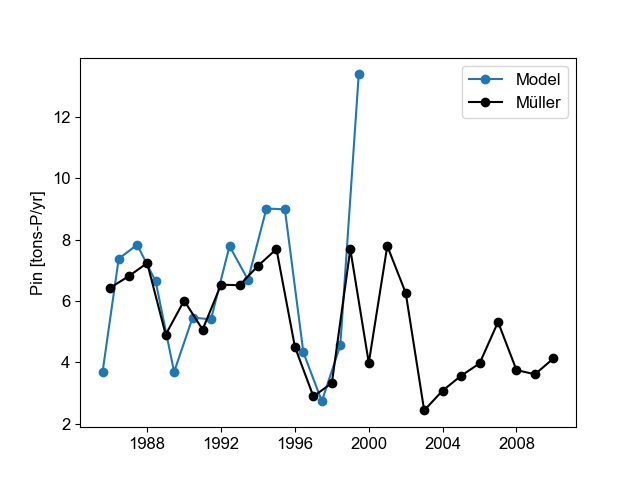

In [29]:
# Compare Pin between model and Müller:
df_P=pd.DataFrame({"Date":tdate_budget,"Year":np.array([dt.year for dt in tdate_budget]),"Pin":P_fluxes["Pin"]})
df_P2=df_P.groupby("Year").mean()
plt.figure()
plt.plot(df_P2["Date"].values,df_P2["Pin"].values,'o-')
plt.plot(df_Muller_model["Jahr"].values,df_Muller_model["AVPin_mod"].values/1000,'ko-')
plt.legend(["Model","Müller"])
plt.ylabel("Pin [tons-P/yr]")

In [30]:
# Export concentrations
df_mod=pd.DataFrame({"tdate":[tdate.strftime("%Y%m%d") for tdate in tdate_predict],"TPepi":TPepi_predict,"TPhypo":TPhypo_predict,"TPlake":TPlake_mod})
df_mod.to_csv("results_model_"+tdate_min_max[0].strftime("%Y")+"_"+tdate_min_max[-1].strftime("%Y")+".csv",sep=",",header=True)
print("Data saved")

Data saved


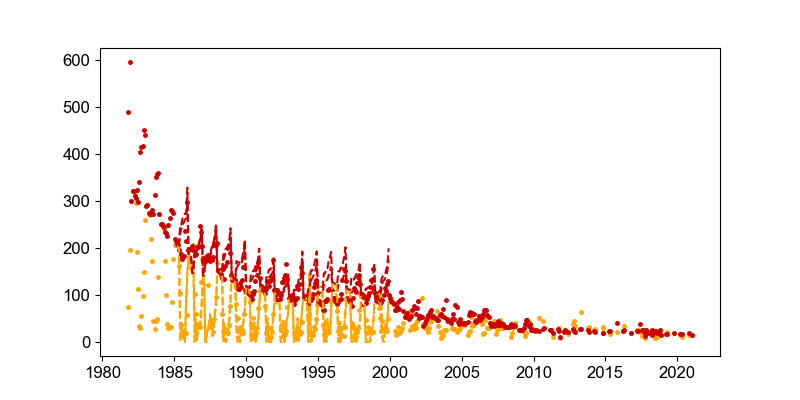

In [31]:
plt.figure(figsize=(8,4))
p1,=plt.plot(tdate_predict,TPepi_predict,'--',color='orange')
p2,=plt.plot(tdate_TP,TPepi,'.',color='orange',markersize=5)
p3,=plt.plot(tdate_predict,TPhypo_predict,'--',color=(0.8,0,0))
p4,=plt.plot(tdate_TP,TPhypo,'.',color=(0.8,0,0),markersize=5)

df_mod_entire=pd.read_csv("results_model_1985_2015.csv",parse_dates=["tdate"])
tnum_entire=df_mod_entire["tdate"].values.astype("datetime64[s]").astype(np.int64)
valkeep=tnum_entire<datetime(2000,1,1).timestamp()
plt.plot(df_mod_entire["tdate"].values[valkeep],df_mod_entire["TPepi"].values[valkeep],'--',color='orange')
plt.plot(df_mod_entire["tdate"].values[valkeep],df_mod_entire["TPhypo"].values[valkeep],'--',color=(0.8,0,0))

## 4. Sensitivity analysis

In [31]:
param_name="Pin"
param_units=""
param_factor=np.concatenate((np.array([1]),10.0**(np.linspace(-1,1,10))))
param_factor=np.sort(param_factor)
paramval,TPepi_sens,TPhypo_sens,TPlake_sens=sensitivity_model(param_name,param_factor,tnum_budget,bool_anox,Pin,Qout_budget,hepi_budget,TPepi_0,TPhypo_0,TPsed,
                                                              z_hypso,A_hypso,T_hypo_budget,T_epi_budget,sigma_max=sigma_max,P_NS_max=P_NS_max,TPcrit=TPcrit,
                     method_sed=method_netsed,method_remob="Nurnberg",cst_input=False,show_output=False)
change_TPavg={"Epi":np.nanmean(TPepi_sens,axis=1)/np.nanmean(TPepi_sens[param_factor==1,:],axis=1),
"Hypo":np.nanmean(TPhypo_sens,axis=1)/np.nanmean(TPhypo_sens[param_factor==1,:],axis=1),
"Lake":np.nanmean(TPlake_sens,axis=1)/np.nanmean(TPlake_sens[param_factor==1,:],axis=1)}

change_TPstd={"Epi":np.nanstd(TPepi_sens,axis=1)/np.nanstd(TPepi_sens[param_factor==1,:],axis=1),
"Hypo":np.nanstd(TPhypo_sens,axis=1)/np.nanstd(TPhypo_sens[param_factor==1,:],axis=1),
"Lake":np.nanstd(TPlake_sens,axis=1)/np.nanstd(TPlake_sens[param_factor==1,:],axis=1)}

p=np.polyfit(tnum_budget,TPepi_sens[0,:],1)


change_TPtrend={"Epi":np.array([np.polyfit(tnum_budget,TPepi_sens[k,:],1)[0] for k in range(len(param_factor))])/np.polyfit(tnum_budget,TPepi_sens[np.where(param_factor==1)[0][0],:],1)[0],
"Hypo":np.array([np.polyfit(tnum_budget,TPhypo_sens[k,:],1)[0] for k in range(len(param_factor))])/np.polyfit(tnum_budget,TPhypo_sens[np.where(param_factor==1)[0][0],:],1)[0],
"Lake":np.array([np.polyfit(tnum_budget,TPlake_sens[k,:],1)[0] for k in range(len(param_factor))])/np.polyfit(tnum_budget,TPlake_sens[np.where(param_factor==1)[0][0],:],1)[0]}


Iteration 1/11
Pin=0.6510135162577879, sigma_max=0.5, PNSmax=4.8
Iteration 2/11
Pin=1.085955996194115, sigma_max=0.5, PNSmax=4.8
Iteration 3/11
Pin=1.811483780627028, sigma_max=0.5, PNSmax=4.8
Iteration 4/11
Pin=3.021737067593139, sigma_max=0.5, PNSmax=4.8
Iteration 5/11
Pin=5.040561225729445, sigma_max=0.5, PNSmax=4.8
Iteration 6/11
Pin=6.510135162577878, sigma_max=0.5, PNSmax=4.8
Iteration 7/11
Pin=8.408162888429077, sigma_max=0.5, PNSmax=4.8
Iteration 8/11
Pin=14.025661031054137, sigma_max=0.5, PNSmax=4.8
Iteration 9/11
Pin=23.39621270048733, sigma_max=0.5, PNSmax=4.8
Iteration 10/11
Pin=39.027234974129755, sigma_max=0.5, PNSmax=4.8
Iteration 11/11
Pin=65.10135162577879, sigma_max=0.5, PNSmax=4.8


Text(0.5, 0.98, 'Pin = 0.65  (0.1*initial_value)')

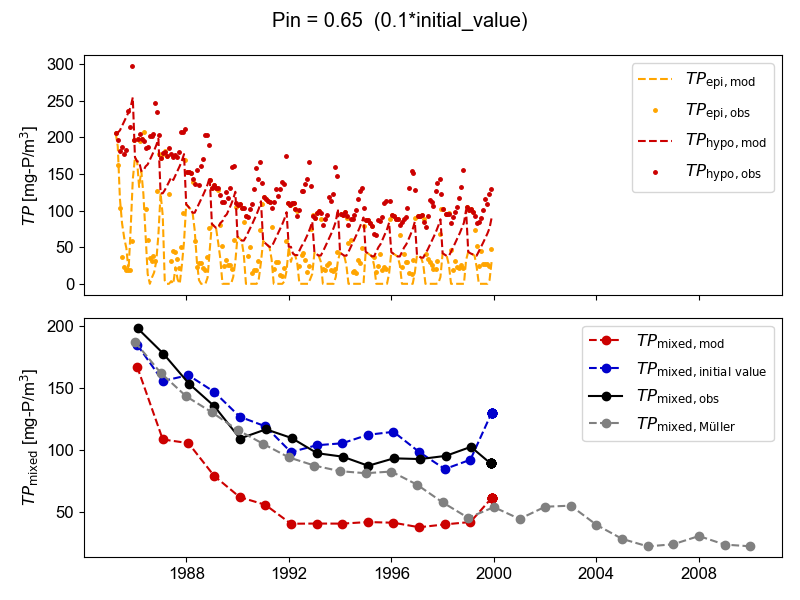

In [32]:
# Plot for a given parameter value
k_iteration=0

fig,ax=plt.subplots(2,1,figsize=(8,6),sharex=True)
colplots=plt.get_cmap('tab10')
tdate_predict=np.array([datetime.fromtimestamp(tnum,UTC) for tnum in tnum_budget])
TPepi_predict=TPepi_sens[k_iteration,:]
TPhypo_predict=TPhypo_sens[k_iteration,:]
TPlake_predict=TPlake_sens[k_iteration,:]
TPlake_nochange=TPlake_sens[np.where(param_factor==1)[0][0],:]

p1,=ax[0].plot(tdate_predict,TPepi_predict,'--',color='orange')
p2,=ax[0].plot(tdate_compare,TPepi_compare,'.',color='orange',markersize=5)
p3,=ax[0].plot(tdate_predict,TPhypo_predict,'--',color=(0.8,0,0))
p4,=ax[0].plot(tdate_compare,TPhypo_compare,'.',color=(0.8,0,0),markersize=5)
ax[0].set_ylabel('$TP$ [mg-P/m$^3$]')
ax[0].legend([p1,p2,p3,p4],["$TP_{\\rm epi,mod}$","$TP_{\\rm epi,obs}$","$TP_{\\rm hypo,mod}$","$TP_{\\rm hypo,obs}$"])


# Define the mixing period from 1st Feb
ind_mod=[np.argmin(np.abs(tdate_predict-dt.replace(tzinfo=timezone.utc))) for dt in df_Muller_model["Jahr"].values.astype("datetime64[s]").astype(datetime)+timedelta(days=31)]
p1,=ax[1].plot(tdate_predict[ind_mod],TPlake_predict[ind_mod],'o--',color=(0.8,0,0))
p2,=ax[1].plot(tdate_predict[ind_mod],TPlake_nochange[ind_mod],'o--',color=(0,0,0.8))
p3,=ax[1].plot(tdate_compare[ind_obs],TPlake_obs[ind_obs],'ko-')
p4,=ax[1].plot(df_Muller_model["Jahr"].values,df_Muller_model["TPmod"].values,'o--',color=(0.5,0.5,0.5))
ax[1].set_ylabel('$TP_{\\rm mixed}$ [mg-P/m$^3$]')
ax[1].legend([p1,p2,p3,p4],["$TP_{\\rm mixed,mod}$","$TP_{\\rm mixed,initial\\ value}$","$TP_{\\rm mixed,obs}$","$TP_{\\rm mixed,Müller}$"])

fig.set_tight_layout(True)
fig.suptitle("{} = {:.2f} {} ({:.1f}*initial_value)".format(param_name,paramval[k_iteration],param_units,param_factor[k_iteration]))

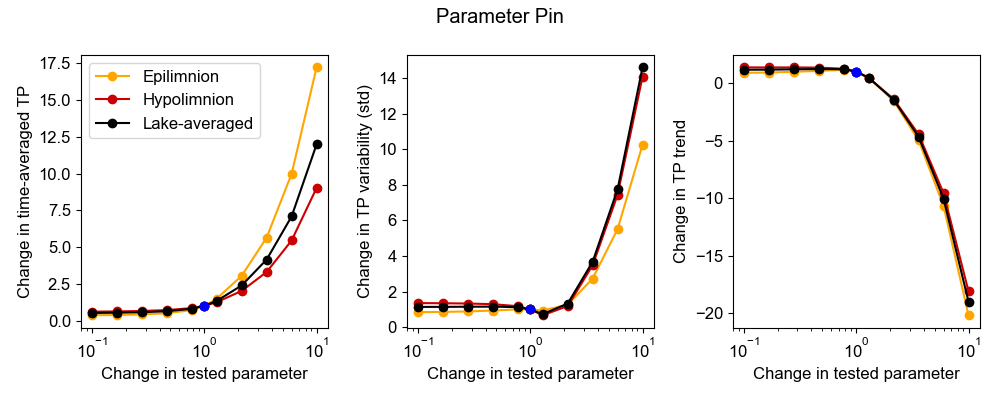

In [33]:
# Plot summarizing the sensitivity analysis
fig,ax=plt.subplots(1,3,figsize=(10,4))

p1,=ax[0].plot(param_factor,change_TPavg["Epi"],'o-',color="orange")
p2,=ax[0].plot(param_factor,change_TPavg["Hypo"],'o-',color=(0.8,0,0))
p3,=ax[0].plot(param_factor,change_TPavg["Lake"],'ko-')
ax[0].plot(1,1,'bo')
ax[0].set_xlabel("Change in tested parameter")
ax[0].set_ylabel("Change in time-averaged TP")
ax[0].set_xscale("log")
ax[0].legend([p1,p2,p3],["Epilimnion","Hypolimnion","Lake-averaged"])
#ax[0].set_yscale("log")

ax[1].plot(param_factor,change_TPstd["Epi"],'o-',color="orange")
ax[1].plot(param_factor,change_TPstd["Hypo"],'o-',color=(0.8,0,0))
ax[1].plot(param_factor,change_TPstd["Lake"],'ko-')
ax[1].plot(1,1,'bo')
ax[1].set_xlabel("Change in tested parameter")
ax[1].set_ylabel("Change in TP variability (std)")
ax[1].set_xscale("log")
#ax[1].set_yscale("log")

ax[2].plot(param_factor,change_TPtrend["Epi"],'o-',color="orange")
ax[2].plot(param_factor,change_TPtrend["Hypo"],'o-',color=(0.8,0,0))
ax[2].plot(param_factor,change_TPtrend["Lake"],'ko-')
ax[2].plot(1,1,'bo')
ax[2].set_xlabel("Change in tested parameter")
ax[2].set_ylabel("Change in TP trend")
ax[2].set_xscale("log")
#ax[2].set_yscale("log")

fig.suptitle("Parameter "+param_name)
fig.set_tight_layout(True)


In [34]:
# Save figure
fig.savefig("../Figures/sensitivity_"+param_name+".png",dpi=400)
fig.savefig("../Figures/sensitivity_"+param_name+".svg")
print('Figure saved!')

Figure saved!
